# 1. Get Data

In [1]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 839M/839M [01:19<00:00, 11.1MB/s] 

Extracting files...


Path to dataset files: /Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1


# 2. Export from matlab and visualize

Dataset Shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor Labels: (3064,)
Unique Labels: [0 1 2]


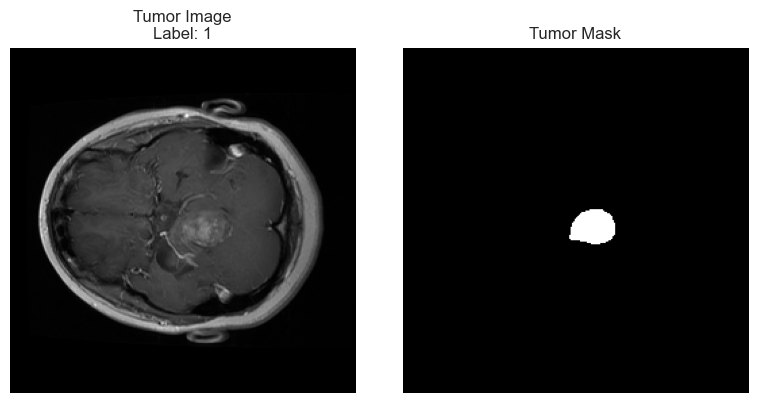

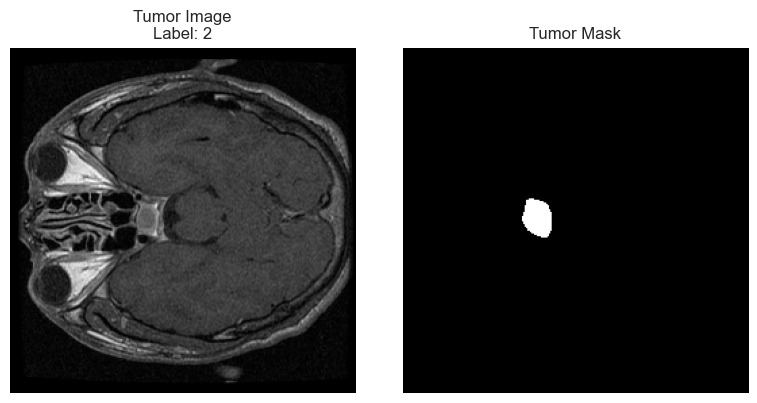

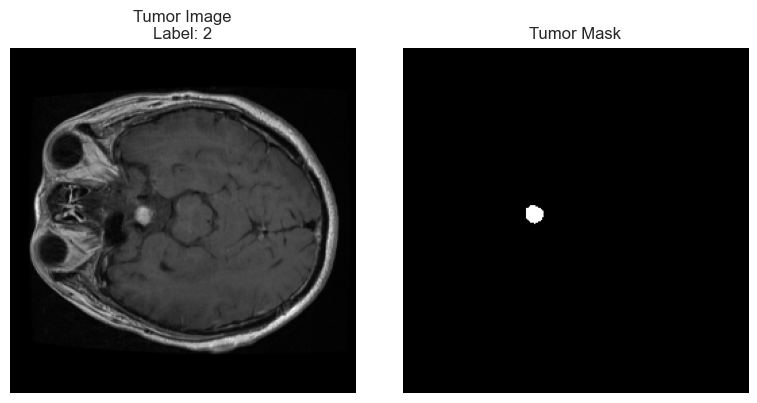

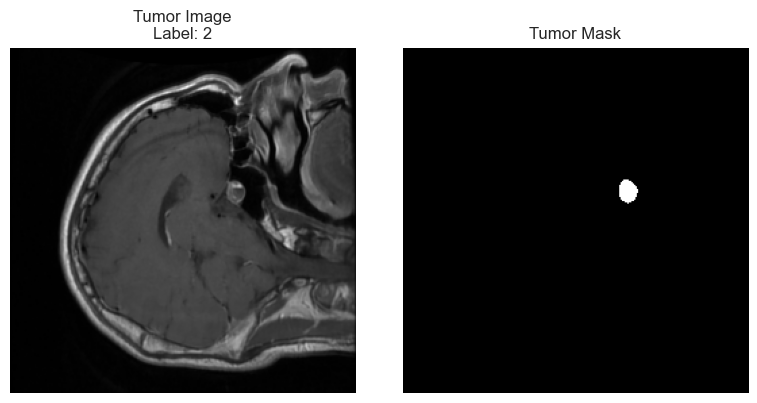

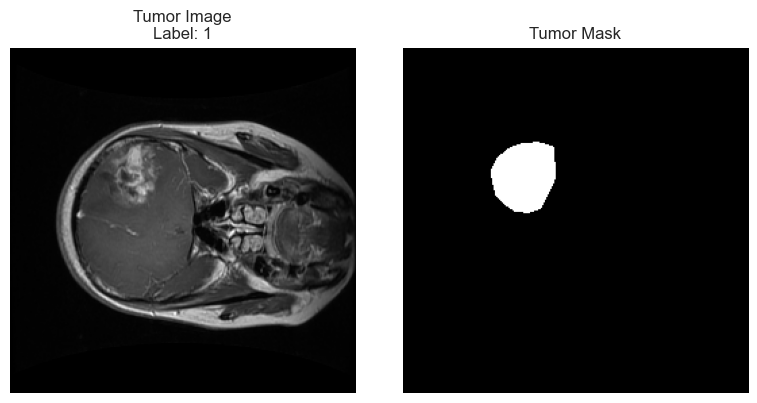

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 1 -> meningioma  2 -> glioma  3 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocessing for Segmentation Only (for now)

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)


Processed X_tumor shape: (3064, 256, 256, 1)


# 4. Custom dataset, Lightning DataModule

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        """
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # make images and masks torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)

        return image, mask

# Lightning dataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset
        full_dataset = BrainTumorDataset(self.images, self.masks)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator=gen
        )
        print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

# set batch size and instantiate data module
batch_size = 16
data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, batch_size=batch_size)
data_module.setup()

# initialize loaders
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
for batch in train_loader:
    images, masks = batch
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)      # same here
    break

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])


# 5. Model, FCNResNet50

In [7]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

# setting seed again to ensure everything is the same every run !!!!!!
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#model
class FCNResNet50Lightning(pl.LightningModule):
    def __init__(self, num_classes=1):
        super().__init__()
        self.save_hyperparameters()
        # load pretrained model
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        # replace classifier with new one for binary segmentation
        self.model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # replicate single channel to 3 channels since model expects RGB input, (won't affect performance)
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        # returns a dictionary, what is needed is the 'out' key
        out = self.model(x)['out']
        # use sigmoid activation to get probabilities
        return torch.sigmoid(out)

    # dice loss function
    def dice_loss(self, preds, targets, epsilon=1e-6):
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * intersection / (union + epsilon)
        return 1 - dice.mean()  # dice loss wil be 1 - current dice coef

    # final combined loss function (BCE + Dice loss with equal contribution)
    def combined_loss(self, preds, masks, bce_weight=0.5, dice_weight=0.5):
        # binary cross entropy
        bce_loss = F.binary_cross_entropy(preds, masks)
        # dice
        dice_loss = self.dice_loss(preds, masks)
        # final loss
        return bce_weight * bce_loss + dice_weight * dice_loss

    # training step with logging
    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # validation step with logging
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self.forward(images)
        loss = self.combined_loss(preds, masks)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    # adam config
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Seed set to 42


# 6. Train

In [8]:
# initialize model and trainer, then train for 10 epochs
model = FCNResNet50Lightning(num_classes=1)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Train size: 2207, Val size: 245, Test size: 612



  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | FCN  | 35.3 M | train
---------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.248   Total estimated model params size (MB)
162       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [03:47<00:00,  0.61it/s, v_num=0, train_loss=0.253]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=0, train_loss=0.130, val_loss=0.282]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [03:50<00:00,  0.60it/s, v_num=0, train_loss=0.133, val_loss=0.223]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [03:49<00:00,  0.60it/s, v_num=0, train_loss=0.209, val_loss=0.184] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [03:51<00:00,  0.60it/s, v_num=0, train_loss=0.146, val_loss=0.174] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=0, train_loss=0.171, val_loss=0.175] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=0, train_loss=0.135, val_loss=0.222] 
Validation: |         

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [03:58<00:00,  0.58it/s, v_num=0, train_loss=0.104, val_loss=0.165]


# 7.1 Validation and Test losses

In [9]:
# validation and test losses
trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Val size: 245, Test size: 612
Validation DataLoader 0: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.16530157625675201
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.




Train size: 2207, Val size: 245, Test size: 612
Testing DataLoader 0: 100%|██████████| 39/39 [00:20<00:00,  1.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.16022957861423492
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.16022957861423492}]

# 7.2 Dice coef

Evaluating Test Set: 100%|██████████| 39/39 [04:05<00:00,  6.30s/it]


Average Dice Coefficient on Test Set: 0.7311


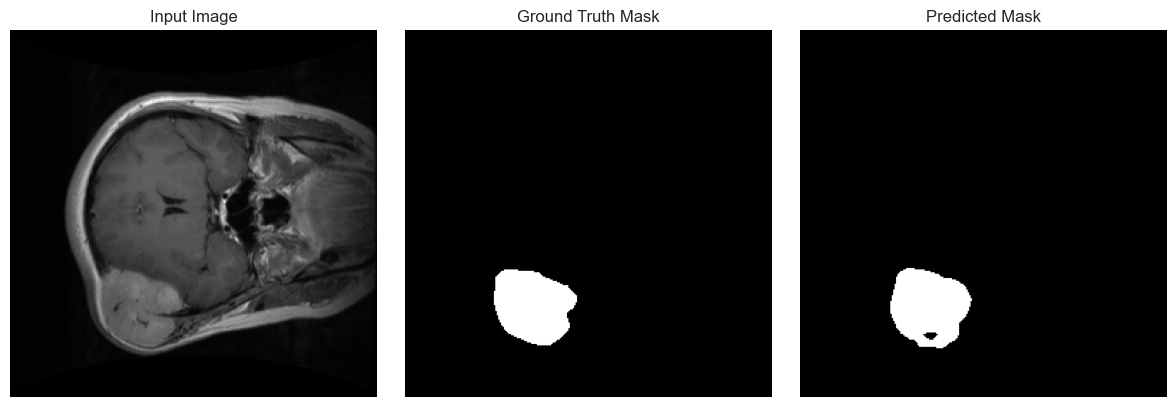

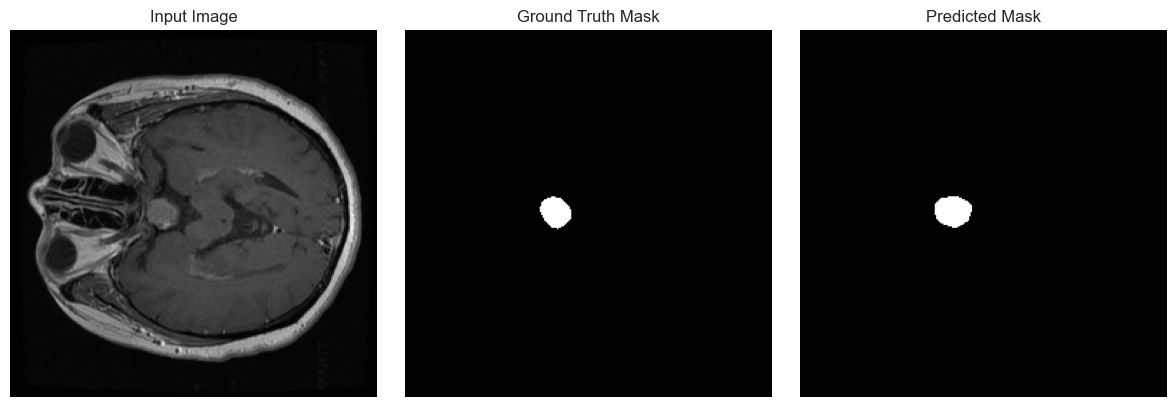

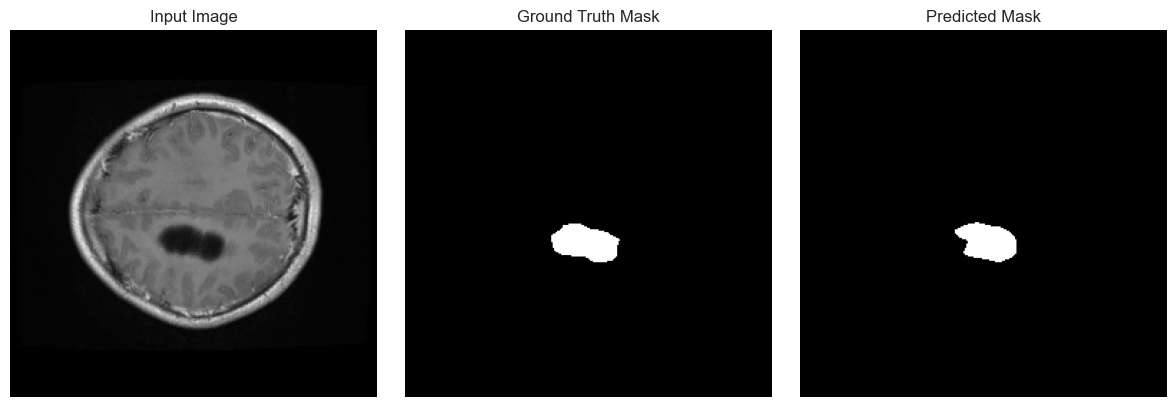

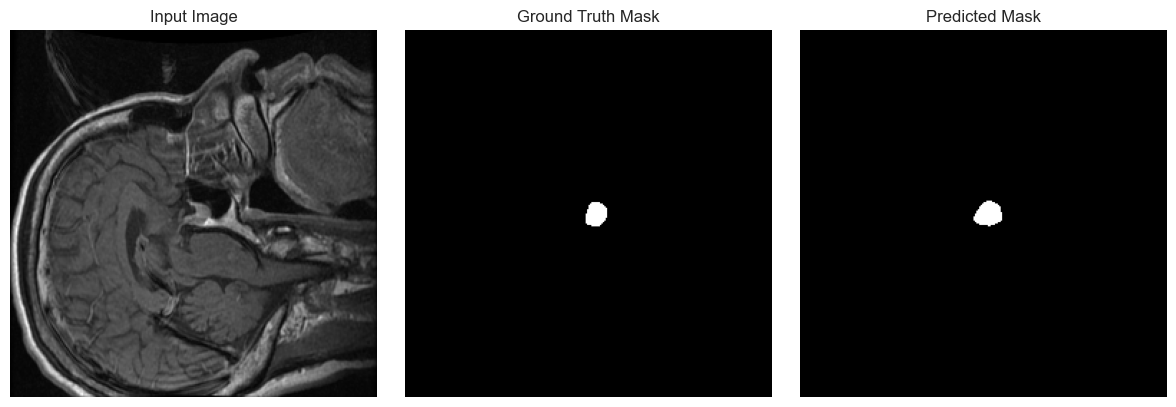

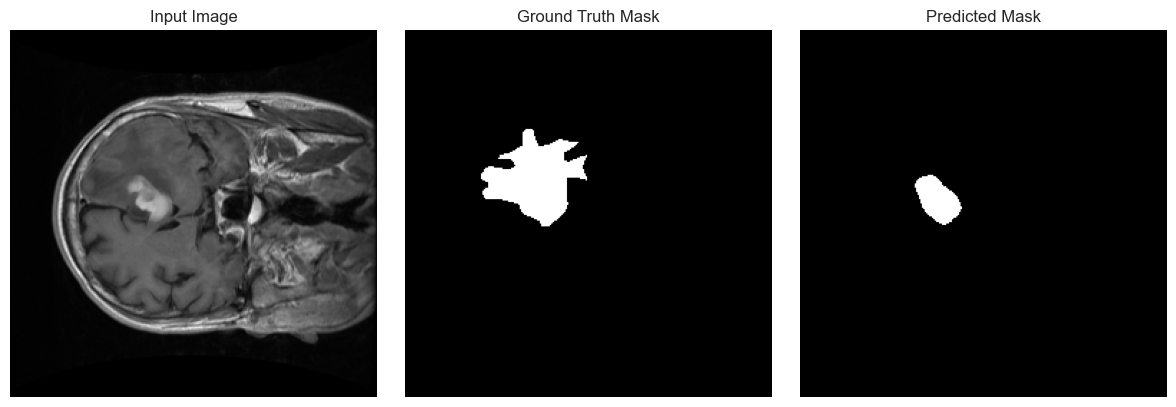

In [10]:
from tqdm import tqdm

# dice coefficient function, follows same structure as the loss
def dice_coefficient(preds, targets, threshold=0.65, epsilon=1e-6):
    preds_bin = (preds > threshold).float()
    intersection = (preds_bin * targets).sum(dim=(1,2,3))
    total = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2.0 * intersection + epsilon) / (total + epsilon)
    return dice.mean()

# set model to evaluation mode and compute dice coef on test set
model.eval()
dice_total = 0.0
n_samples = 0

all_images = []
all_masks = []
all_preds = []

with torch.no_grad():
    # progress bar to see time needed
    for images, masks in tqdm(test_loader, desc="Evaluating test set"):
        preds = model(images)
        # this computes dice for the current batch
        batch_dice = dice_coefficient(preds, masks)
        dice_total += batch_dice.item() * images.size(0)
        n_samples += images.size(0)

        # save for final visualization
        all_images.append(images)
        all_masks.append(masks)
        all_preds.append(preds)

avg_dice = dice_total / n_samples
print(f"Average dice coefficient on test set: {avg_dice:.4f}")

# visualization
images = torch.cat(all_images, dim=0)
masks = torch.cat(all_masks, dim=0)
preds = torch.cat(all_preds, dim=0)

# display for say 5 examples
num_samples = 5
indices = torch.randperm(images.shape[0])[:num_samples]

for idx in indices:
    image = images[idx].cpu().numpy().squeeze()
    mask = masks[idx].cpu().numpy().squeeze()
    pred = preds[idx].cpu().numpy().squeeze()

    pred_bin = (pred > 0.5).astype(float)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground truth mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_bin, cmap='gray')
    plt.title("Predicted mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# 7.3 IoU coefficient

In [11]:
# IoU coefficient function
def iou_coefficient(preds, targets, threshold=0.5, epsilon=1e-6):
    preds_bin = (preds > threshold).float()
    intersection = (preds_bin * targets).sum(dim=(1,2,3))
    union = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - intersection
    iou = (intersection + epsilon) / (union + epsilon)  # use epsilon to avoid division by 0
    return iou.mean()


model.eval()
iou_total = 0.0
n_samples = 0


all_images = []
all_masks = []
all_preds = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Evaluating test set"):

        preds = model(images)
        batch_iou = iou_coefficient(preds, masks)
        iou_total += batch_iou.item() * images.size(0)
        n_samples += images.size(0)

        all_images.append(images)
        all_masks.append(masks)
        all_preds.append(preds)

avg_iou = iou_total / n_samples
print(f"Average IoU on test set: {avg_iou:.4f}")

Evaluating Test Set: 100%|██████████| 39/39 [03:59<00:00,  6.13s/it]

Average IoU on Test Set: 0.6352


# Save model

In [12]:
trainer.save_checkpoint("checkpoints/segmentation_alone.ckpt")